In [ ]:
#Code For Final Project

In [ ]:
#@title Necessary Library Packages
import os
import numpy as np
import tensorflow as tf
import itertools
import time

import keras

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.metrics import mean_squared_error as fun_mse


import matplotlib
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import regularizers, layers
from sklearn.model_selection import train_test_split

from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#@title Loading Data File
!wget https://raw.githubusercontent.com/mhrafiei/data/main/concrete_compressive_strength.csv

--2023-12-13 00:27:24--  https://raw.githubusercontent.com/mhrafiei/data/main/concrete_compressive_strength.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41747 (41K) [text/plain]
Saving to: ‘concrete_compressive_strength.csv’

concrete_compressiv 100%[===================>]  40.77K  --.-KB/s    in 0.005s  

2023-12-13 00:27:24 (7.27 MB/s) - ‘concrete_compressive_strength.csv’ saved [41747/41747]



#Steps 1 and 2: Data Prep and Preprocessing


In [ ]:
#@title Deep Neural Network Data Processing
data_nn      = pd.read_csv('/content/concrete_compressive_strength.csv')

# only 28-dat concrete strength
ind  = data_nn['Age (day)'].values == 28
data_nn = data_nn.iloc[ind,:]
data_nn = data_nn.drop(['Age (day)'], axis = 1 )


#get all before first '(' for simplicity
data_keys = list(data_nn.keys())
keys = []
for i0 in data_keys:
  keys.append(i0[:i0.find('(')])

datain_nn = data_nn.iloc[:,:-1]
dataou_nn = data_nn.iloc[:,-1:]

datain_nn = datain_nn.values
dataou_nn = dataou_nn.values

#scale data
scaler_in = MinMaxScaler()
scaler_out = MinMaxScaler()
scaled_datain = scaler_in.fit_transform(datain_nn)
scaled_dataou = scaler_out.fit_transform(dataou_nn)
datain_nn_tr_calibrated = scaled_datain
dataou_nn_tr_calibrated = scaled_dataou
# necessary information for combinatory model
num_data      = datain_nn.shape[0]
num_variables = datain_nn.shape[1]

Text(0, 0.5, 'Occurances')

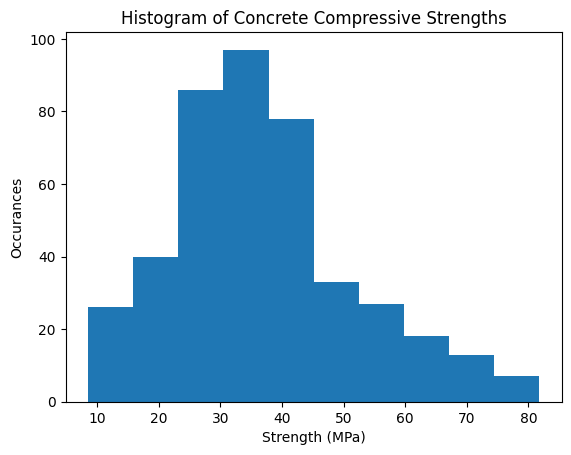

In [ ]:
plt.hist(dataou_nn)
plt.title('Histogram of Concrete Compressive Strengths')
plt.xlabel('Strength (MPa)')
plt.ylabel('Occurances')
#the model is estimating an optimal strength of 58 MPa which is on the higher end so that's good

Text(0, 0.5, 'Occurances')

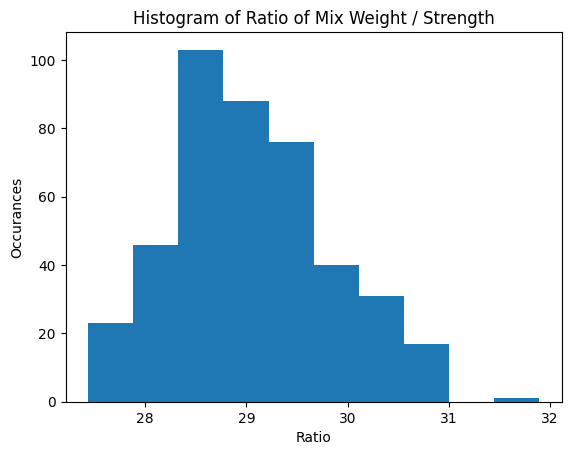

In [ ]:
weights = np.sum(np.array(datain_nn), axis=1)
plt.hist(weights.T/dataou_nn[0])
plt.title('Histogram of Ratio of Mix Weight / Strength')
plt.xlabel('Ratio')
plt.ylabel('Occurances')

# Step 3: Deep Neural Network Development

In [ ]:
#@title Define neural network parameters
in_neurons = datain_nn_tr_calibrated.shape[1]
ou_neurons = dataou_nn_tr_calibrated.shape[1]

val_split  = 0.1

hn_neurons = [64,32, 16, 8]

ac_fun     = ['relu', 'relu', 'relu', 'relu', 'linear']

ls_fun     = 'mean_squared_error'
op_val     = 'adam'
it_val     = 1000
bt_size    = 512
sh_val     = True # shuffle
vr_val     = 1    # learning to be printed


In [ ]:
#@title Building Neural Network to include Parameter
model_dnn = tf.keras.models.Sequential() # back-to-back layers of neurons (platform)
model_dnn.add( tf.keras.layers.Dense(units=hn_neurons[0], activation=ac_fun[0], input_dim = in_neurons) ) # 1st hidden layer
model_dnn.add(layers.Dropout(0.2))
model_dnn.add( tf.keras.layers.Dense(units=hn_neurons[1], activation=ac_fun[1]) )                         # 2nd hidden layer
model_dnn.add(layers.Dropout(0.2))
model_dnn.add( tf.keras.layers.Dense(units=hn_neurons[2], activation=ac_fun[2]) )                         # 3rd hidden layer
model_dnn.add(layers.Dropout(0.2))
model_dnn.add( tf.keras.layers.Dense(units=hn_neurons[3], activation=ac_fun[3]) )                         # 4th hidden layer
model_dnn.add(layers.Dropout(0.2))
model_dnn.add( tf.keras.layers.Dense(units=ou_neurons   , activation=ac_fun[4]) )                         # output layer

model_dnn.compile(optimizer = op_val, loss = ls_fun) # compile the network

#Model Summary
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 1

In [ ]:
#@title Train the network
history = model_dnn.fit(datain_nn_tr_calibrated,
                  dataou_nn_tr_calibrated,
                  epochs           = it_val,
                  batch_size       = bt_size,
                  verbose          = vr_val,
                  shuffle          = sh_val,
                  validation_split = val_split)

Epoch 1/1000
1/1 [==============================] - 8s 8s/step - loss: 0.3227 - val_loss: 0.2286
Epoch 2/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.3054 - val_loss: 0.2049
Epoch 3/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.2671 - val_loss: 0.1855
Epoch 4/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.2404 - val_loss: 0.1716
Epoch 5/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.2266 - val_loss: 0.1623
Epoch 6/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.2134 - val_loss: 0.1551
Epoch 7/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.1998 - val_loss: 0.1491
Epoch 8/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.1866 - val_loss: 0.1438
Epoch 9/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.1878 - val_loss: 0.1386
Epoch 10/1000
1/1 [==============================] - 0s 29ms/step - loss: 0.1775 - val_loss: 0.1337
Epoch 11/10

In [ ]:
#@title Estimate outputs of testing data
dataes_nn_tr_calibrated = model_dnn.predict(datain_nn_tr_calibrated)

14/14 [==============================] - 1s 67ms/step


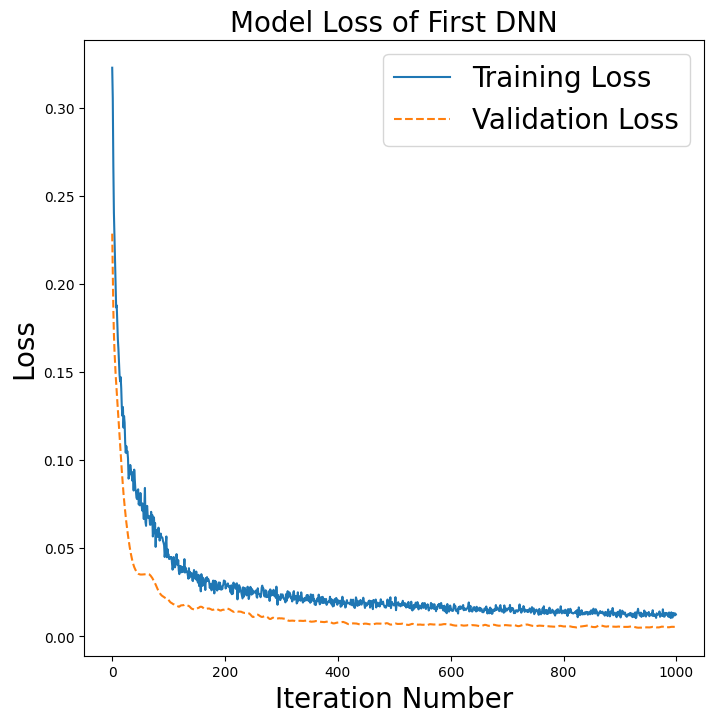

In [ ]:
#@title Plot iteration vs Model Loss
plt.figure(figsize=[8,8])
plt.plot(history.history['loss'],'-')
plt.plot(history.history['val_loss'],'--')
plt.title('Model Loss of First DNN', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Iteration Number', fontsize = 20)
plt.legend(['Training Loss', 'Validation Loss'], fontsize = 20)
plt.savefig('Model_Loss_Vs_Iteration_DNN.png')


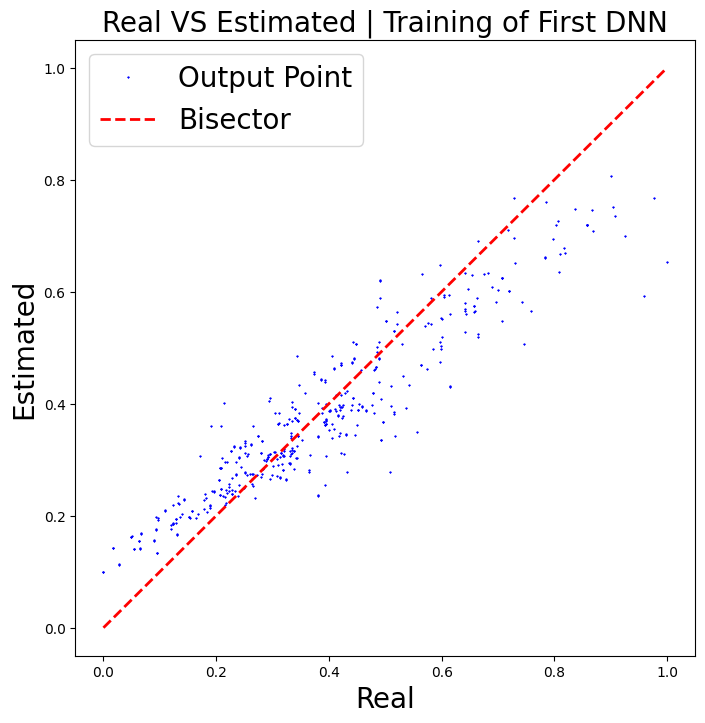

In [ ]:
#@title Plot testing real vs estimated values for Training
plt.figure(figsize=[8,8])
plt.plot(dataou_nn_tr_calibrated.ravel(), dataes_nn_tr_calibrated.ravel(), 'b*',markersize = 1)
plt.plot([0,1], [0,1],'r--',linewidth = 2)
plt.title('Real VS Estimated | Training of First DNN', fontsize = 20)
plt.xlabel('Real', fontsize = 20)
plt.ylabel('Estimated', fontsize = 20)
plt.legend(['Output Point','Bisector'], fontsize = 20)
plt.savefig('Real_VS_Estimation_Training_DNN.png')

# Step 4: GAN Model Development

In [ ]:
#@title Data Preprocessing For GAN Network

def _df(data):
    df = pd.DataFrame(data)
    for c in range(df.shape[1]):
        mapping = {df.columns[c]: c}
        df = df.rename(columns=mapping)
    return df

datain = _df(scaled_datain)
dataou = _df(scaled_dataou)

In [ ]:
#@title GAN Model Preliminaries

class Gan():

    def __init__(self, data):

        self.data = data
        self.n_epochs = 500
        self.num_batch = 5


    def _noise(self):
        noise = np.random.normal(0, 1, self.data.shape)
        return noise

        #Generator Function

    def _generator(self):
        model = tf.keras.Sequential(name="Generator_model")

        model.add(tf.keras.layers.Dense(32, activation='relu',input_dim=self.data.shape[1]))

        model.add(tf.keras.layers.Dense(64, activation='relu'))

        model.add(tf.keras.layers.Dense(16, activation='relu',))

        model.add(tf.keras.layers.Dense(self.data.shape[1], activation='linear'))
        return model

    #Discriminator Function

    def _discriminator(self):
        model = tf.keras.Sequential(name="Discriminator_model")

        model.add(tf.keras.layers.Dense(32, activation='relu', input_dim=self.data.shape[1]))
        model.add(layers.Dropout(0.2))

        model.add(tf.keras.layers.Dense(16, activation='relu'))
        model.add(layers.Dropout(0.2))

        model.add(tf.keras.layers.Dense(8, activation='relu',))
        model.add(layers.Dropout(0.2))

        # sigmoid => real or fake

        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    #Combines the GAN

    def _GAN(self, generator, discriminator):
        discriminator.trainable = False
        generator.trainable = True
        model = tf.keras.Sequential(name="GAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

    # train the generator and discriminator
    def train(self, generator, discriminator, gan):

    # determine half the size of one batch, for updating the  discriminator
    # manually enumerate epochs
        for i0 in range(self.n_epochs):
          for i1 in range(self.num_batch):

            # Train the discriminator
            generated_data = generator.predict(self._noise())
            labels = np.concatenate([np.ones(self.data.shape[0]), np.zeros(self.data.shape[0])])
            X = np.concatenate([self.data, generated_data])
            discriminator.trainable = True
            d_loss , _ = discriminator.train_on_batch(X, labels)

            # Train the generator
            noise = self._noise()
            g_loss = gan.train_on_batch(noise, np.ones(self.data.shape[0]))


            print("Epoch {:02d} | Batch {:02d} | D__loss={:.3f} | G_loss={:.3f}".format(i0+1, i1 + 1, d_loss, g_loss))

        return generator


    def _test(self):
        noise = self._noise()
        return noise


In [ ]:
#@title Train and Predict GAN

model = Gan(data=datain)
generator = model._generator()
#generator.summary()
descriminator = model._discriminator()
#descriminator.summary()
gan_model = model._GAN(generator=generator, discriminator=descriminator)
#gan_model.summary()
trained_model = model.train(generator=generator, discriminator=descriminator, gan=gan_model)

#Generate 575 new data points

noise = np.random.normal(0, 1, (575,7))


14/14 [==============================] - 0s 2ms/step
Epoch 01 | Batch 01 | D__loss=0.685 | G_loss=0.706
14/14 [==============================] - 1s 54ms/step
Epoch 01 | Batch 02 | D__loss=0.686 | G_loss=0.704
14/14 [==============================] - 0s 2ms/step
Epoch 01 | Batch 03 | D__loss=0.687 | G_loss=0.701
14/14 [==============================] - 0s 16ms/step
Epoch 01 | Batch 04 | D__loss=0.688 | G_loss=0.695
14/14 [==============================] - 0s 2ms/step
Epoch 01 | Batch 05 | D__loss=0.682 | G_loss=0.693
14/14 [==============================] - 0s 2ms/step
Epoch 02 | Batch 01 | D__loss=0.683 | G_loss=0.694
14/14 [==============================] - 0s 2ms/step
Epoch 02 | Batch 02 | D__loss=0.679 | G_loss=0.691
14/14 [==============================] - 0s 2ms/step
Epoch 02 | Batch 03 | D__loss=0.683 | G_loss=0.688
14/14 [==============================] - 0s 2ms/step
Epoch 02 | Batch 04 | D__loss=0.681 | G_loss=0.690
14/14 [==============================] - 0s 20ms/step
Epoch 02

# Step 5: Generate 575 New Data Points

In [ ]:
#@title Produce 575 New Data Points
new_data = data=trained_model.predict(noise)

18/18 [==============================] - 0s 2ms/step


In [ ]:
hiddenin=np.random.normal(0, 3, (575,7))
new_datatest = data=trained_model.predict(hiddenin)
new_data_estest = model_dnn.predict(new_datatest)
new_data_dfintest = _df(scaler_in.inverse_transform(new_datatest))
new_data_es_dfoutest = _df((scaler_out.inverse_transform(new_data_estest)))
dfnt = pd.DataFrame(new_data_dfintest)
dfnt["8"] = new_data_es_dfoutest
dfnt.to_csv('new_GAN_datatest.csv')

18/18 [==============================] - 0s 2ms/step


In [ ]:
#@title Estimate Outputs
new_data_es = model_dnn.predict(new_data)

18/18 [==============================] - 0s 4ms/step


In [ ]:
#@title Export GAN estimated data
new_data_dfin = _df(scaler_in.inverse_transform(new_data))
new_data_es_dfou = _df((scaler_out.inverse_transform(new_data_es)))
dfn = pd.DataFrame(new_data_dfin)
dfn["8"] = new_data_es_dfou
dfn.to_csv('new_GAN_data.csv')



# Step 6: Second DNN

In [ ]:
#@title Data Preprocessing For Second DNN Network

full_datain = np.append(scaled_datain,new_data, axis = 0)
full_dataou = np.append(scaled_dataou,new_data_es, axis = 0)


In [ ]:
#@title Define neural network parameters
in_neurons = full_datain.shape[1]
ou_neurons = full_dataou.shape[1]

val_split  = 0.1

hn_neurons = [56, 32, 16, 8]

ac_fun     = ['relu', 'relu', 'relu', 'relu', 'linear']

ls_fun     = 'mean_squared_error'
op_val     = 'adam'
it_val     = 1000
bt_size    = 512
sh_val     = True # shuffle
vr_val     = 1    # learning to be printed


In [ ]:
#@title Building Neural Network to include Parameter
model_dnn2 = tf.keras.models.Sequential() # back-to-back layers of neurons (platform)
model_dnn2.add( tf.keras.layers.Dense(units=hn_neurons[0], activation=ac_fun[0], input_dim = in_neurons) ) # 1st hidden layer
model_dnn2.add(layers.Dropout(0.2))
model_dnn2.add( tf.keras.layers.Dense(units=hn_neurons[1], activation=ac_fun[1]) )                         # 2nd hidden layer
model_dnn2.add(layers.Dropout(0.2))
model_dnn2.add( tf.keras.layers.Dense(units=hn_neurons[2], activation=ac_fun[2]) )                         # 3rd hidden layer
model_dnn2.add(layers.Dropout(0.2))
model_dnn2.add( tf.keras.layers.Dense(units=hn_neurons[3], activation=ac_fun[3]) )                         # 4th hidden layer
model_dnn2.add(layers.Dropout(0.2))
model_dnn2.add( tf.keras.layers.Dense(units=ou_neurons   , activation=ac_fun[4]) )                         # output layer

model_dnn2.compile(optimizer = op_val, loss = ls_fun) # compile the network

#Model Summary
model_dnn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 64)                512       
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 16)                528       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 8)                

In [ ]:
#@title Train the network
history_dnn2 = model_dnn2.fit(full_datain,
                  full_dataou,
                  epochs           = it_val,
                  batch_size       = bt_size,
                  verbose          = vr_val,
                  shuffle          = sh_val,
                  validation_split = val_split)

Epoch 1/1000
2/2 [==============================] - 2s 158ms/step - loss: 0.1841 - val_loss: 0.1585
Epoch 2/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.1543 - val_loss: 0.1288
Epoch 3/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.1378 - val_loss: 0.1077
Epoch 4/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.1181 - val_loss: 0.0932
Epoch 5/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.1063 - val_loss: 0.0792
Epoch 6/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0912 - val_loss: 0.0635
Epoch 7/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0812 - val_loss: 0.0481
Epoch 8/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0660 - val_loss: 0.0336
Epoch 9/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0620 - val_loss: 0.0211
Epoch 10/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0567 - val_loss: 0.0117
Epoch 11

In [ ]:
#@title Estimate outputs of 1000 data points
full_dataou_es = model_dnn2.predict(full_datain)

32/32 [==============================] - 1s 16ms/step


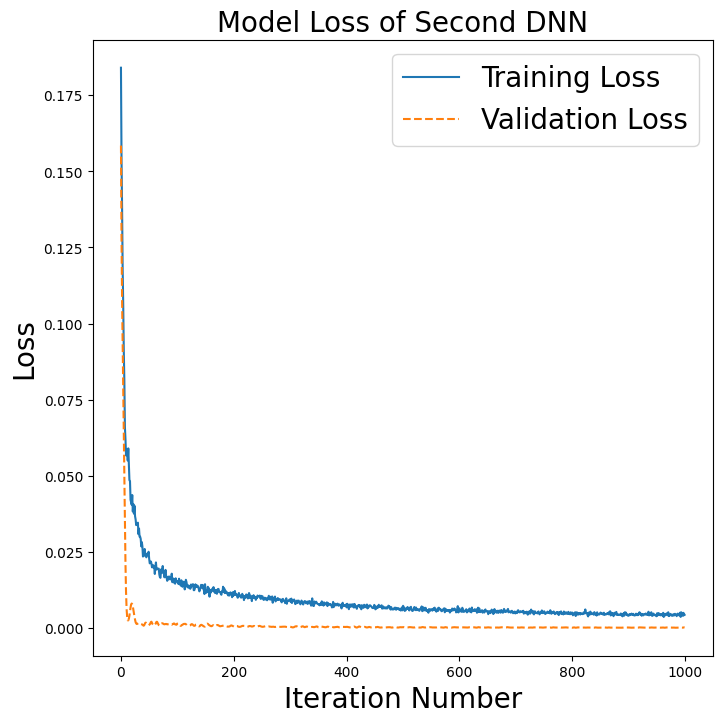

In [ ]:
#@title Plot iteration vs Model Loss
plt.figure(figsize=[8,8])
plt.plot(history_dnn2.history['loss'],'-')
plt.plot(history_dnn2.history['val_loss'],'--')
plt.title('Model Loss of Second DNN', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Iteration Number', fontsize = 20)
plt.legend(['Training Loss', 'Validation Loss'], fontsize = 20)
plt.savefig('Model_Loss_Vs_Iteration_DNN_2.png')


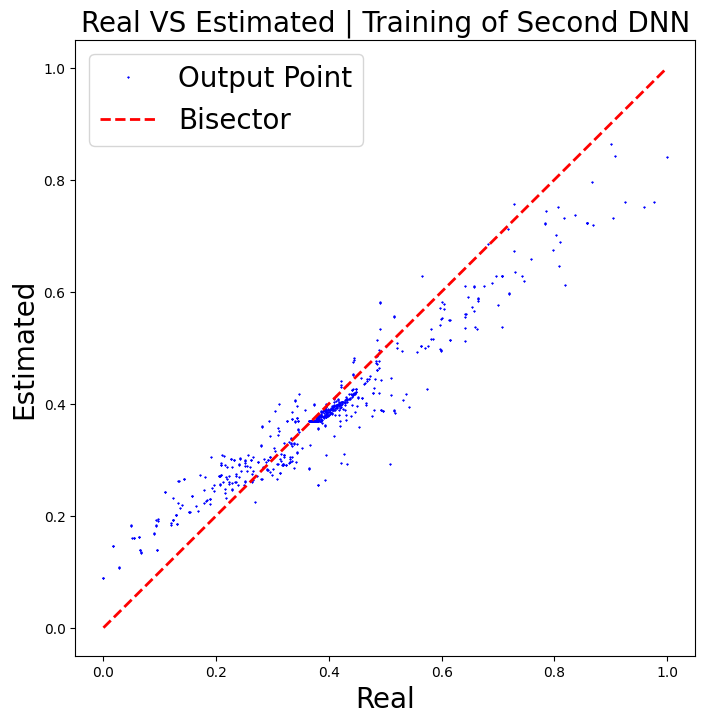

In [ ]:
#@title Plot testing real vs estimated values for Training
plt.figure(figsize=[8,8])
plt.plot(full_dataou, full_dataou_es, 'b*',markersize = 1)
plt.plot([0,1], [0,1],'r--',linewidth = 2)
plt.title('Real VS Estimated | Training of Second DNN', fontsize = 20)
plt.xlabel('Real', fontsize = 20)
plt.ylabel('Estimated', fontsize = 20)
plt.legend(['Output Point','Bisector'], fontsize = 20)
plt.savefig('Real_VS_Estimation_Training_DNN_2.png')

# Step 7: Combinatory Pattern Recognition Model

In [ ]:
#@title Some necessary functions
# Used from examples in Module 10
def fun_combinations(num_data, num_variables):
  num_comb = 2**num_variables - 1
  comb_bin = np.zeros((num_comb,num_variables))
  comb_ind = []

  counter  = 0
  for i0 in range(num_variables):
    ind       = list(itertools.combinations(range(num_variables),i0+1))
    comb_ind.append(ind)

    for i1 in range(len(ind)):
      comb_bin[counter,ind[i1]] = 1
      counter                   = counter + 1

  comb_bin = comb_bin.astype(dtype = np.bool)

  return comb_bin, comb_ind, num_comb

def fun_split(RTT, RRS, num_data):
  np.random.seed(42)

  index_te = []
  index_tr = []

  for rtt in RTT:
    index_te_tmp = []
    index_tr_tmp = []

    for rrs in range(RRS):
      index = list(range(num_data))
      index = np.ndarray.tolist(np.random.permutation(index))

      index_te_tmp.append(index[0:int(np.floor(rtt*num_data))])
      index_tr_tmp.append(index[int(np.floor(rtt*num_data)):])

    index_te.append(index_te_tmp)
    index_tr.append(index_tr_tmp)

  return index_tr, index_te

def fun_prep(datain, dataou, comb_bin, index_tr, index_te, lb, ub):
  datain_tr = datain[index_tr, :][:, comb_bin] # this way we avoid "mismatch" error in indexing
  datain_te = datain[index_te, :][:, comb_bin] # this way we avoid "mismatch" error in indexing
  dataou_tr = dataou[index_tr,:]
  dataou_te = dataou[index_te,:]

  if len(datain_tr.shape) == 1:
    datain_tr = np.expand_dims(datain_tr, axis = 1)
    datain_te = np.expand_dims(datain_te, axis = 1)

  if len(dataou_tr.shape) == 1:
    dataou_tr = np.expand_dims(dataou_tr, axis = 1)
    dataou_te = np.expand_dims(dataou_te, axis = 1)

  scalerin = MinMaxScaler(feature_range=(lb,ub))
  scalerin.fit(datain_tr)

  scalerou = MinMaxScaler(feature_range=(lb,ub))
  scalerou.fit(dataou_tr)

  datain_tr_calibrated = scalerin.transform(datain_tr)
  datain_te_calibrated = scalerin.transform(datain_te)

  dataou_tr_calibrated = scalerou.transform(dataou_tr)
  dataou_te_calibrated = scalerou.transform(dataou_te)

  return datain_tr_calibrated, dataou_tr_calibrated, datain_te_calibrated, dataou_te_calibrated


def fun_ml(datain_tr, dataou_tr, datain_te, dataou_te, model_type):

  result = {}

  if model_type == 'DNN':

    hdarray = np.array([28, 10, 1])
    ac_fun     = ['relu', 'relu', 'linear']
    epochs = 10
    batch_size = 512
    validation_split = 0.1
    #Dropout = 0.1

    # functional API method for creating a tf model

    mdl= tf.keras.models.Sequential() # back-to-back layers of neurons (platform)
    mdl.add( tf.keras.layers.Dense(units=hdarray[0], activation=ac_fun[0], input_dim = datain_tr.shape[1]) ) # 1st hidden layer
    mdl.add( tf.keras.layers.Dense(units=hdarray[1], activation=ac_fun[1]) )                         # 2nd hidden layer
    mdl.add( tf.keras.layers.Dense(units=hdarray[2]   , activation=ac_fun[2]) )                         # output layer


    adam_bc = tf.keras.optimizers.Adam(
        learning_rate=0.05,
        beta_1=0.5,
    )

    mdl.compile(optimizer = adam_bc,
                  loss = 'mse') # compile the network


  else:
    print("Model type has not been defined!")

  result['model_type'] = model_type
  history = mdl.fit(datain_tr,
                      dataou_tr,
                      epochs = epochs,
                      batch_size = batch_size,
                      verbose = 0,
                      validation_split = validation_split,
                      shuffle = True)
  dataes_tr            = mdl.predict(datain_tr)
  dataes_te            = mdl.predict(datain_te)
  result['mse_tr']     = fun_mse(dataes_tr, dataou_tr)
  result['mse_te']     = fun_mse(dataes_te, dataou_te)

  return result

In [ ]:
#@title Combinatory main run
num_data      = full_datain.shape[0]
num_variables = full_datain.shape[1]
import warnings
warnings.filterwarnings("ignore")

model_type = ['DNN']
RTT        = [0.1]

RRS        = 3

comb_bin, _, num_comb = fun_combinations(num_data, num_variables)
index_tr, index_te           = fun_split(RTT, RRS, num_data)
time_start = time.time()
result = np.empty((len(RTT), RRS, num_comb, len(model_type)), dtype = dict)

counter = 1
for i0 in range(num_comb):
  for i1 in range(len(RTT)):
    for i2 in range(RRS):
      datain_tr, dataou_tr, datain_te, dataou_te = fun_prep(full_datain, full_dataou, comb_bin[i0,:], index_tr[i1][i2], index_te[i1][i2], 0, 1)
      for i3 in range(len(model_type)):
        result[i1,i2,i0,i3] = fun_ml(datain_tr, dataou_tr, datain_te, dataou_te, model_type[i3])
        print("Comb #: {:05d}/{} | RTT #: {:05d}/{} | RRS #: {:05d}/{} | Model: {} | Completed {:07.3F}%".format(i0+1, num_comb, i1+1, len(RTT), i2+1, RRS, model_type[i3], counter/(num_comb * len(RTT) * RRS * len(model_type))*100))
        counter = counter + 1
run_time = time.time() - time_start
print('Run Time')
print(run_time)

4/4 [==============================] - 0s 2ms/step
Comb #: 00001/127 | RTT #: 00001/1 | RRS #: 00001/3 | Model: DNN | Completed 000.262%
4/4 [==============================] - 1s 197ms/step
Comb #: 00001/127 | RTT #: 00001/1 | RRS #: 00002/3 | Model: DNN | Completed 000.525%
4/4 [==============================] - 1s 284ms/step
Comb #: 00001/127 | RTT #: 00001/1 | RRS #: 00003/3 | Model: DNN | Completed 000.787%
4/4 [==============================] - 0s 3ms/step
Comb #: 00002/127 | RTT #: 00001/1 | RRS #: 00001/3 | Model: DNN | Completed 001.050%
4/4 [==============================] - 1s 287ms/step
Comb #: 00002/127 | RTT #: 00001/1 | RRS #: 00002/3 | Model: DNN | Completed 001.312%
4/4 [==============================] - 1s 293ms/step
Comb #: 00002/127 | RTT #: 00001/1 | RRS #: 00003/3 | Model: DNN | Completed 001.575%
4/4 [==============================] - 1s 283ms/step
Comb #: 00003/127 | RTT #: 00001/1 | RRS #: 00001/3 | Model: DNN | Completed 001.837%
4/4 [==========================

In [ ]:
#@title Result function
def fun_result(result, model_type, comb_bin):
  num_rtt, num_rrs, num_comb, num_model = result.shape
  result_summary                        = {}

  for i3 in range(num_model):
    res_tr = np.empty((num_comb, 1))
    res_te = np.empty((num_comb, 1))

    for i0 in range(num_comb):

      mse_te = np.empty((num_rtt, num_rrs))
      mse_tr = np.empty((num_rtt, num_rrs))

      for i1 in range(num_rtt):
        for i2 in range(num_rrs):
          mse_tr[i1,i2] = result[i1, i2, i0, i3]['mse_tr']
          mse_te[i1,i2] = result[i1, i2, i0, i3]['mse_te']

      res_tr[i0,0] = mse_tr.mean()
      res_te[i0,0] = mse_te.mean()

    mse_tr_sorted  = np.sort(res_tr, axis = 0)[:,0]
    mse_tr_index   = np.argsort(res_tr, axis = 0)[:,0]

    mse_te_sorted  = np.sort(res_te, axis = 0)[:,0]
    mse_te_index   = np.argsort(res_te, axis = 0)[:,0]

    #print(mse_te_index)

    result_summary[model_type[i3]] = {'mse_tr&te'  : [mse_tr_sorted, res_te[mse_tr_index,0]],
                                      'comb_bin_tr': comb_bin[mse_tr_index,:],
                                      'mse_te&tr'  : [mse_te_sorted, res_tr[mse_te_index,0]],
                                      'comb_bin_te': comb_bin[mse_te_index,:]}

  return result_summary


Best Combinations and Their Corresponding MSEs
----------------------------------------------
              Cement   Blast Furnace Slag   Fly Ash   Water    \
DNN Training        1                    1         0        1   
DNN Testing         1                    1         0        1   

              Superplasticizer   Coarse Aggregate    Fine Aggregate   \
DNN Training                  1                   0                0   
DNN Testing                   1                   0                0   

              MSE Training  MSE Testing  
DNN Training      0.006476     0.008265  
DNN Testing       0.008265     0.006476  


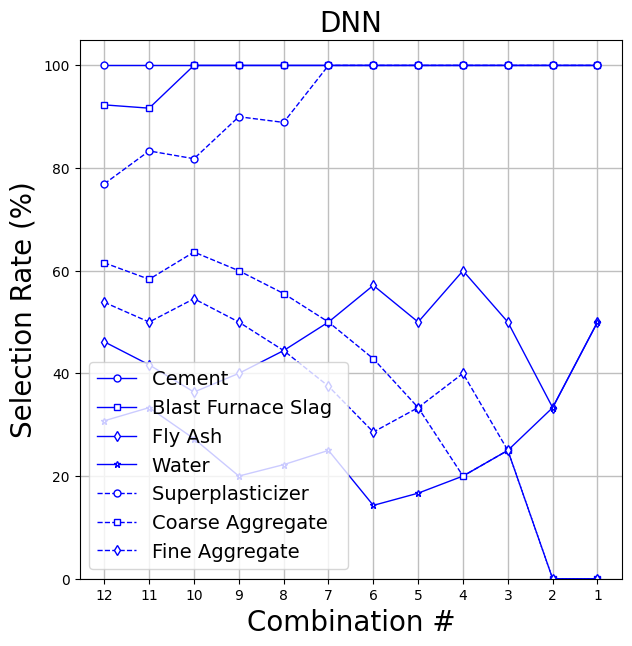

In [ ]:
#@title Results and summaries
result_summary = fun_result(result, model_type, comb_bin)

#########################################
# Create a report about best combinations
#########################################
df = {}
# add combinations
for i0 in range(datain.shape[1]):
  comb_best = []
  index     = []
  for i1 in range(len(model_type)):
    comb_best_tr = result_summary[model_type[i1]]['comb_bin_tr'][0,i0]*1
    comb_best_te = result_summary[model_type[i1]]['comb_bin_te'][0,i0]*1

    comb_best.append(comb_best_tr)
    comb_best.append(comb_best_te)

  df[keys[i0]] = comb_best

# add mse and data frame index (i.e., row names)
index       = []
mse_best_tr = []
mse_best_te = []
for i1 in range(len(model_type)):
  mse_best_tr.append(result_summary[model_type[i1]]['mse_tr&te'][0][0])
  mse_best_te.append(result_summary[model_type[i1]]['mse_tr&te'][1][0])

  mse_best_tr.append(result_summary[model_type[i1]]['mse_te&tr'][0][0])
  mse_best_te.append(result_summary[model_type[i1]]['mse_te&tr'][1][0])

  index.append(model_type[i1] + ' Training')
  index.append(model_type[i1] + ' Testing')

df['MSE Training'] = mse_best_tr
df['MSE Testing']  = mse_best_te

df = pd.DataFrame(df, index=index)
df.to_csv('report.csv')
print("Best Combinations and Their Corresponding MSEs")
print("----------------------------------------------")
print(df)

df_summary = df

#######################################
# Create a report about selection rates
#######################################
col_val    = ['bo-','bs-','bd-','b*-','bo--','bs--','bd--','b*--','bo:','bs:','bd:','b*:']
for i1 in range(len(model_type)):
  comb_cumsum = np.cumsum(result_summary[model_type[i1]]['comb_bin_tr']*1, axis = 0)
  comb_denom  = np.repeat(np.expand_dims(np.array(range(1,comb_cumsum.shape[0]+1)), axis = 1), comb_cumsum.shape[1], axis = 1)
  comb_rate   = comb_cumsum / comb_denom  * 100

  filename = 'Selection_Rates_' +  model_type[i1] + '.csv'
  comb_dict = {}

  # top 10% num
  num_top    = int(comb_rate.shape[0] * 0.1)
  comb_label = []
  for i2 in range(num_top,0,-1):
    comb_label.append(str(i2))

  plt.figure(figsize = [7,7])
  for i2 in range(len(keys[:-1])):
    comb_dict[keys[i2]] = comb_rate[:,i2]

    # plot top 10% selection rates

    plt.plot(comb_rate[range(num_top,0,-1),i2],
             col_val[i2],
             linewidth = 1,
             markersize = 5,
             markerfacecolor = 'w')

  plt.xlabel('Combination #', fontsize = 20)
  plt.ylabel('Selection Rate (%)', fontsize = 20)
  plt.title(model_type[i1], fontsize = 20)
  plt.xticks(np.arange(num_top), np.arange(num_top,0,-1))
  plt.grid(color=[.75,.75,.75], linestyle='-', linewidth=1, which='both')
  plt.ylim([0,105])
  plt.legend(keys[:-1], fontsize = 14)

  df = pd.DataFrame(comb_dict)
  df.to_csv(filename)

# Step 8: Third DNN with Best Combination

In [ ]:
#Alter Dataset with Best Combination
full_datain_bc = np.delete(full_datain, [2,5,6], axis=1)


In [ ]:
#@title Define neural network parameters
in_neurons = full_datain_bc.shape[1]
ou_neurons = full_dataou.shape[1]

val_split  = 0.1

hn_neurons = [56, 32, 16, 8]

ac_fun     = ['relu', 'relu', 'relu', 'relu', 'linear']

ls_fun     = 'mean_squared_error'
op_val     = 'adam'
it_val     = 1000
bt_size    = 512
sh_val     = True # shuffle
vr_val     = 1    # learning to be printed


In [ ]:
#@title Building Neural Network to include Parameter
model_dnn3 = tf.keras.models.Sequential() # back-to-back layers of neurons (platform)
model_dnn3.add( tf.keras.layers.Dense(units=hn_neurons[0], activation=ac_fun[0], input_dim = in_neurons) ) # 1st hidden layer
model_dnn3.add(layers.Dropout(0.2))
model_dnn3.add( tf.keras.layers.Dense(units=hn_neurons[1], activation=ac_fun[1]) )                         # 2nd hidden layer
model_dnn3.add(layers.Dropout(0.2))
model_dnn3.add( tf.keras.layers.Dense(units=hn_neurons[2], activation=ac_fun[2]) )                         # 3rd hidden layer
model_dnn3.add(layers.Dropout(0.2))
model_dnn3.add( tf.keras.layers.Dense(units=hn_neurons[3], activation=ac_fun[3]) )                         # 4th hidden layer
model_dnn3.add(layers.Dropout(0.2))
model_dnn3.add( tf.keras.layers.Dense(units=ou_neurons   , activation=ac_fun[4]) )                         # output layer

model_dnn3.compile(optimizer = op_val, loss = ls_fun) # compile the network

#Model Summary
model_dnn3.summary()

Model: "sequential_387"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1181 (Dense)          (None, 56)                280       
                                                                 
 dropout_27 (Dropout)        (None, 56)                0         
                                                                 
 dense_1182 (Dense)          (None, 32)                1824      
                                                                 
 dropout_28 (Dropout)        (None, 32)                0         
                                                                 
 dense_1183 (Dense)          (None, 16)                528       
                                                                 
 dropout_29 (Dropout)        (None, 16)                0         
                                                                 
 dense_1184 (Dense)          (None, 8)              

In [ ]:
#@title Train the network
history_dnn3 = model_dnn3.fit(full_datain_bc,
                  full_dataou,
                  epochs           = it_val,
                  batch_size       = bt_size,
                  verbose          = vr_val,
                  shuffle          = sh_val,
                  validation_split = val_split)

Epoch 1/1000
2/2 [==============================] - 1s 133ms/step - loss: 0.0962 - val_loss: 0.0688
Epoch 2/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0804 - val_loss: 0.0439
Epoch 3/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0655 - val_loss: 0.0232
Epoch 4/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0611 - val_loss: 0.0103
Epoch 5/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0576 - val_loss: 0.0043
Epoch 6/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0593 - val_loss: 0.0024
Epoch 7/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0516 - val_loss: 0.0021
Epoch 8/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.0528 - val_loss: 0.0030
Epoch 9/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.0533 - val_loss: 0.0052
Epoch 10/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.0468 - val_loss: 0.0085
Epoch 11

In [35]:
#@title Estimate outputs of Best Combination datapoints
full_dataou_es_bc = model_dnn3.predict(full_datain_bc)

NameError: ignored

In [ ]:
#@title Plot iteration vs Model Loss
plt.figure(figsize=[8,8])
plt.plot(history_dnn3.history['loss'],'-')
plt.plot(history_dnn3.history['val_loss'],'--')
plt.title('Model Loss of Third DNN with Best Combination', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Iteration Number', fontsize = 20)
plt.legend(['Training Loss', 'Validation Loss'], fontsize = 20)
plt.savefig('Model_Loss_Vs_Iteration_DNN_3.png')


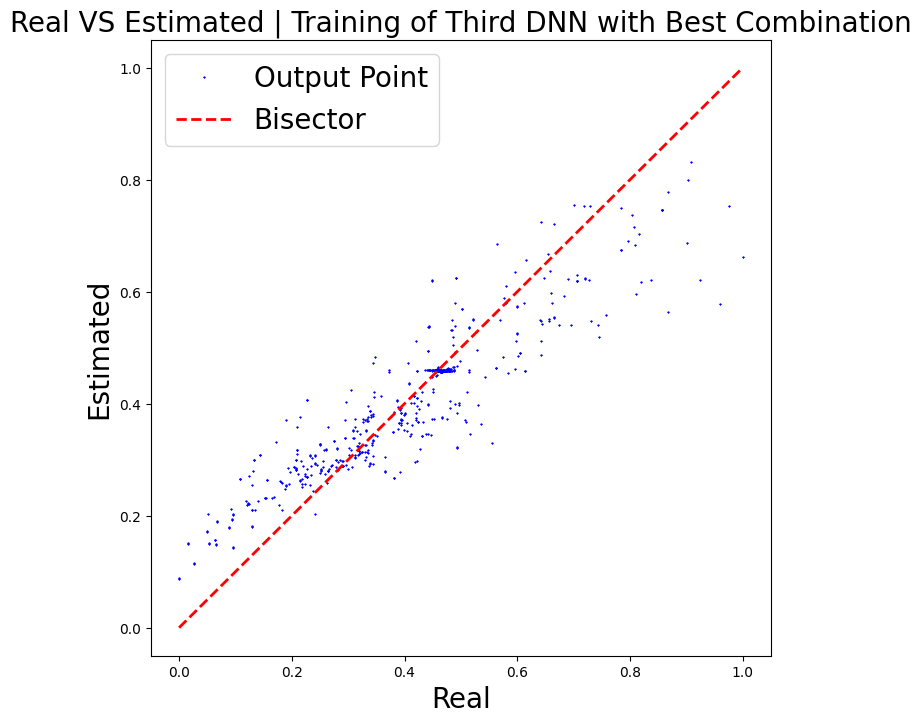

In [ ]:
#@title Plot testing real vs estimated values for Training
plt.figure(figsize=[8,8])
plt.plot(full_dataou, full_dataou_es_bc, 'b*',markersize = 1)
plt.plot([0,1], [0,1],'r--',linewidth = 2)
plt.title('Real VS Estimated | Training of Third DNN with Best Combination', fontsize = 20)
plt.xlabel('Real', fontsize = 20)
plt.ylabel('Estimated', fontsize = 20)
plt.legend(['Output Point','Bisector'], fontsize = 20)
plt.savefig('Real_VS_Estimation_Training_DNN_3.png')

#Step 9: Optimization Model Development

In [ ]:
#@title Optimization Model

#goal: max strength/weight --> min weight/strength
    #mix weight = sum of all 7 components
    #water = component 4
    #cement = component 1
    #28-day concrete compressive strength = S (predict using model)

#define initial x array, generates x1, x2,...,x7 between 0 - 1
xi = np.random.uniform(low = 0, high = 1, size = 7)
#bounds - all X between 0 - 1 (scaled)
bounds = ((0,1),)*7

#Objective Function
def fun_objective(X):
    #alter input data to reflect best combination
    xi_bc = np.delete(X, [2,5,6])
    #use DNN to predict strength for this single datapoint
    S = model_dnn3.predict(tf.expand_dims(xi_bc, axis=0))

    #undo min/max scaler to get values in original format
    S_scaled = float(scaler_out.inverse_transform(S.reshape(1, -1)))
    x_scaled = scaler_in.inverse_transform(X.reshape(1, -1))
    return 1/S_scaled * sum(sum(x_scaled))

#Constraints
def fun_constraint1(X):
    #undo min/max scaler to get values in original format
    x_scaled = scaler_in.inverse_transform(X.reshape(1, -1))
    return sum(sum(x_scaled)) - 2300

def fun_constraint2(X):
    #undo min/max scaler to get values in original format
    x_scaled = scaler_in.inverse_transform(X.reshape(1, -1))
    return 2500 - sum(sum(x_scaled))

def fun_constraint3(X):
    #undo min/max scaler to get values in original format
    x_scaled = scaler_in.inverse_transform(X.reshape(1, -1))
    return (x_scaled[0, 3]/x_scaled[0, 0]) - 0.48

def fun_constraint4(X):
    #undo min/max scaler to get values in original format
    x_scaled = scaler_in.inverse_transform(X.reshape(1, -1))
    return 0.59 - (x_scaled[0, 3]/x_scaled[0, 0])

#combine
constraint1 = {'type': 'ineq'  , 'fun': fun_constraint1}
constraint2 = {'type': 'ineq'  , 'fun': fun_constraint2}
constraint3 = {'type': 'ineq'  , 'fun': fun_constraint3}
constraint4 = {'type': 'ineq'  , 'fun': fun_constraint4}
constraint_all = ([constraint1, constraint2, constraint3, constraint4])

In [ ]:
#@title Run Optimization
res = minimize(fun_objective, x0 = xi, method='SLSQP', bounds=bounds, constraints=constraint_all)
res

NameError: ignored

In [ ]:
#@title Print Results
x_sol = res.x
x_sol_scaled = scaler_in.inverse_transform(x_sol.reshape(1, -1))
obj = res.fun

print('X Solution (calibrated):', x_sol)
print('')
print('Concrete Mix (unscaled):', x_sol_scaled)
print('')
print('Objective Function Value (mix weight / strength):', obj)